C:\Users\FALCON\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\FALCON\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\FALCON\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

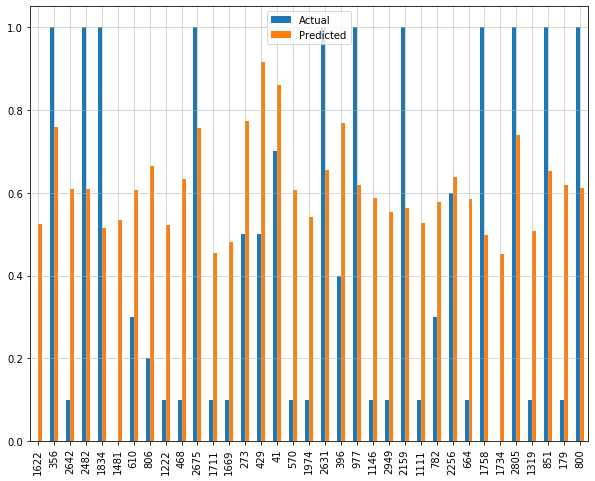

In [2]:
#import libraries
import pandas as pd
import numpy as np

#load csv file of Station ID:AN142 of 2015 into pandas DataFrame
df=pd.read_csv(r'AN142_2015.csv',skiprows=6)

#Dropping rows and columns with invalid or no data
df.drop(index=0, inplace=True)
df.drop(columns=['Station_ID','precip_accum_set_1','wind_chill_set_1d','wet_bulb_temperature_set_1d','wind_cardinal_direction_set_1d'],axis=1,inplace=True)

#customizing Date_Time column
df[['Date','Time','Zone']] = df.Date_Time.apply(lambda x: pd.Series(str(x).split(" ")))
df.drop(columns=['Date_Time'],axis=1,inplace=True)
df.loc[:,'Date_Time'] = df.loc[:,'Date'].map(str)+" "+ df.loc[:,'Time'].map(str)
df.loc[:,'Date_Time']= pd.to_datetime(df.loc[:,'Date_Time'])
df.drop(columns=['Date','Time','Zone'],axis=1,inplace=True)

#Changing datatypes of columns from objects to appropriate datatypes
convert_dict = {'pressure_set_1':float, 'air_temp_set_1':float, 'relative_humidity_set_1':float,
       'wind_speed_set_1':float, 
       'dew_point_temperature_set_1d':float, 'sea_level_pressure_set_1d':float,'heat_index_set_1d':float,
       'altimeter_set_1d':float}

#Filling up missing values with mean values
df = df.astype(convert_dict)
[df[col].fillna(df[col].mean(), inplace=True) for col in convert_dict]

#Filling up missing values with median values
df.loc[:,'wind_direction_set_1']=df.loc[:,'wind_direction_set_1'].astype(float)
[df.loc[:,'wind_direction_set_1'].fillna(df.loc[:,'wind_direction_set_1'].median(), inplace=True)]

#load csv file of SO2 data of 2015 into pandas DataFrame
df1=pd.read_csv(r'hourly_42401_2015.csv',header=0,usecols=[5,6,9,10,13])
cols=list(df1.columns)
df2=pd.DataFrame({})

#extacting the data for Station ID:AN421 using nearest Latitude and Longitude
df2=df1.loc[(df1.Latitude>=33.65060)&(df1.Latitude<=33.73060)&(df1.Longitude>=-84.77310)&(df1.Longitude<=-83.87310)]
df2.drop(columns=['Latitude','Longitude'],axis=1,inplace=True)
df2.reset_index(drop=True,inplace=True)

#Changing format of Date_Time column
df2.loc[:,'Date Local'] = pd.to_datetime(df2.loc[:,'Date Local'])
df2.loc[:,'Date Local'] = df2.loc[:,'Date Local'].dt.strftime('%m/%d/%Y')
df2.loc[:,'Date_Time'] = df2.loc[:,'Date Local'].map(str)+" "+ df2.loc[:,'Time Local']
df2.drop(columns=['Date Local','Time Local'],axis=1,inplace=True)
df2.loc[:,'Date_Time']= pd.to_datetime(df2.loc[:,'Date_Time']) 

#Merging two DataFrame for Prediction of PM2.5 particle
dfinal1 = df.merge(df2, on="Date_Time", how = 'inner')
dfinal1[['Date','Time']] = dfinal1.Date_Time.apply(lambda x: pd.Series(str(x).split(" ")))
dfinal1.drop(columns=['Date_Time','Date'],axis=1,inplace=True)
dfinal1.reset_index(drop=True,inplace=True)

#customizing Time column for retriving hour values
dfinal1.loc[:,'Time'].replace(":00:00",'')
dfinal1.loc[:,'Time']=dfinal1.loc[:,'Time'].str.replace(":00:00",'').astype(float)


#Splitting train and test data randomly in 80-20 ratio
split = np.random.rand(len(dfinal1)) < 0.2
test=dfinal1[split]
train=dfinal1[~split]

#Labeling X_train and Y_train for training data
Y_train=train.loc[:,'Sample Measurement'].tolist()
train.drop(['Sample Measurement'], axis=1,inplace=True)
X_train = train[train.columns]

#Labeling X_test and Y_test for test data
Y_test=test.loc[:,'Sample Measurement'].tolist()
test.drop(['Sample Measurement'], axis=1,inplace=True)
X_test = test[test.columns]

import matplotlib.pyplot as plt  
a=np.zeros([X_train.shape[1],X_train.shape[0]])
for i in range(X_train.shape[0]):
    for j in range(0,X_train.shape[1]):
         a[j,i]=X_train.iloc[i,j]

trans_a=np.transpose(a)
A=np.matmul(a,trans_a)
B=np.matmul(a,Y_train)
if np.linalg.det(A)==0:
    A_inv=np.linalg.pinv(A)
else:A_inv=np.linalg.inv(A)  

#Parameter vector    
W=np.matmul(A_inv,B)

#Predicted values
yout=[]
for i in range(len(X_test)):
    yout.append(np.dot(W,X_test.iloc[i,:]))

#Plotting bar graph
new = pd.DataFrame({'Actual': Y_test, 'Predicted': yout})
result=new.sample(35)
result.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()